In [38]:
import os
import json
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

In [39]:
# Pembacaan Parameter Dataset
filename = "parameter.json"
with open(filename, 'r') as f:
    params = json.load(f)

In [40]:
# Function to read dataset.csv
def read_csv(filepath, row=True):
    df = pd.read_csv(filepath, header=None)
    if row: # row data
        data = df.T.values.tolist()[0]
    else: # comma-separated column data
        data = df.values.tolist()[0]
    return data
def read_raw(filepath):
    raw = []
    with open(filepath) as f:
        # read all lines into list of string
        lines = f.readlines()
        for line in lines:
            # remove leading and trailing white spaces and split by comma delimiter
            raw += line.strip().split(',')
    raw = [complex(s.replace('i', 'j')) for s in raw]
    return raw

In [41]:
# dataset_folder = 'E:\Read-Dataset-Publik-Radar-FMCW-\Children Dataset'
dataset_folder = 'D:\Icen\Bimbingan TA\Read-Dataset-Publik-Radar-FMCW-\Children Dataset\Children Dataset'
radar_raw_folder = os.path.join(dataset_folder, "FMCW Radar\Rawdata")
radar_vital_folder = os.path.join(dataset_folder, "FMCW Radar\Heart Rate & Breathing Rate")
ref_raw_folder = os.path.join(dataset_folder, "Nihon Kohden\Heartbeat & Breathing Waveform")
ref_vital_folder = os.path.join(dataset_folder, "Nihon Kohden\Heart Rate & Breathing Rate")
subject_stats_folder = os.path.join(dataset_folder, "Participant\Human Data")
subject_photo_folder = os.path.join(dataset_folder, "Participant\Picture")

# Subject
subject_id = 1
radar_raw_path = os.path.join(radar_raw_folder, f"Rawdata_{subject_id}.csv")
raw_data = read_raw(radar_raw_path)## Pemanggilan Dataset Dari Folder 
# Merubah data list ke Array 
raw_data = np.asarray(raw_data, dtype=complex)
n_samples = raw_data.shape[0]//params['n_rx']
# print(raw_data.shape[0])
raw_radar = raw_data.reshape(params['n_rx'],n_samples, order='C')
raw_new = raw_radar.reshape((params['n_rx'],params['n_adc']*params['n_chirp'],-1), order='F')
#read heart rate (HR) and breath rate (BR) reading from reference device
ref_hr_path = os.path.join(ref_vital_folder, f"Ref_Heart_{subject_id}.csv")
ref_br_path = os.path.join(ref_vital_folder, f"Ref_Breath_{subject_id}.csv")
# Radar Paper
# read heart rate (HR) and breath rate (BR) estimation from radar
hr_radar_path = os.path.join(radar_vital_folder, f"Heart_{subject_id}.csv")
br_radar_path = os.path.join(radar_vital_folder, f"Breath_{subject_id}.csv")
#df_radar = pd.read_csv(hr_radar_path, header=None)
hr_radar = read_csv(hr_radar_path, row=True)
br_radar = read_csv(br_radar_path, row=True)
#df_hr = pd.read_csv(ref_hr_path, header=None)
hr = read_csv(ref_hr_path, row=False)
br = read_csv(ref_br_path, row=False)
# Waveform 
radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{subject_id}.csv")
radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{subject_id}.csv")
br_wave =np.array(read_csv(radar_br_wave_path))
hr_wave =np.array(read_csv(radar_hr_wave_path,row=True))

In [42]:
import csv
for i in range(1, 51):
    radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{i}.csv")
    radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{i}.csv")
    br_wave =np.array(read_csv(radar_br_wave_path)).reshape(1,-1)
    hr_wave =np.array(read_csv(radar_hr_wave_path,row=True)).reshape(1,-1)
    for j in range(4):
        with open('br_wave.csv', 'a') as f: 
            # Create a CSV writer object that will write to the file 'f'
            csv_writer = csv.writer(f)
        
            # Write all of the rows of data to the CSV file
            csv_writer.writerows(br_wave)
        with open('hr_wave.csv', 'a') as f: 
            # Create a CSV writer object that will write to the file 'f'
            csv_writer = csv.writer(f)
        
            # Write all of the rows of data to the CSV file
            csv_writer.writerows(hr_wave)

In [43]:
br_target = []
hr_target = []

with open('br_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        br_target.append(lines)
        
with open('hr_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        hr_target.append(lines)

In [44]:
br_target_array = []
hr_target_array = []
for i in range(0, 400, 2):
    br_target_array.append(br_target[i])
    hr_target_array.append(hr_target[i])
    
br_target_array = np.array(br_target_array).astype(np.int64)
hr_target_array = np.array(hr_target_array).astype(np.int64)

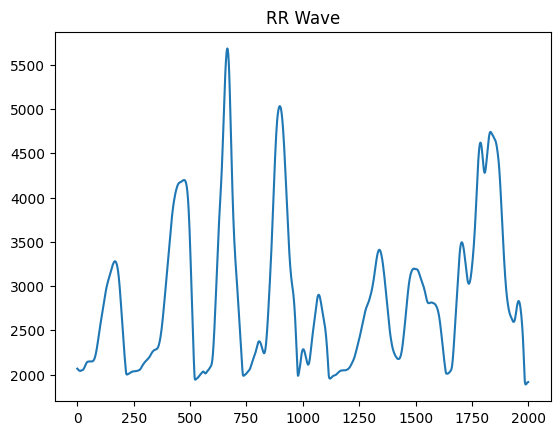

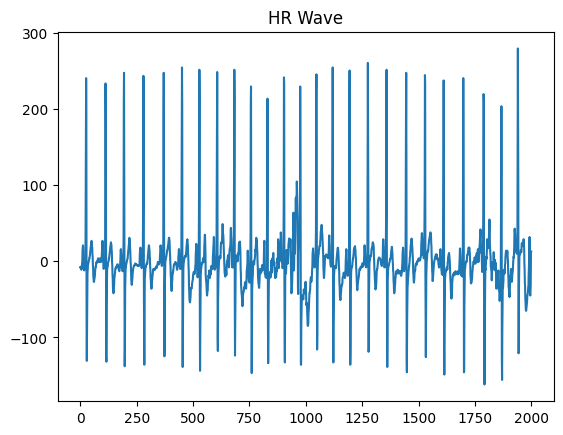

In [45]:
plt.figure(1)
plt.title("RR Wave")
plt.plot(br_target_array[0][:2000],label="RR Wave")
plt.figure(2)
plt.title("HR Wave")
plt.plot(hr_target_array[0][:2000],label="HR Wave")

In [46]:
from sklearn.preprocessing import PowerTransformer
from scipy import signal

pt = PowerTransformer()

hr_norm = pt.fit_transform(hr_target_array[0].reshape(-1, 1))

hr_downsampled_signal = signal.resample(hr_norm, 32000)


print("Ukuran sinyal asli:", hr_target_array[0].shape)
print("Ukuran sinyal setelah downsampling:", hr_downsampled_signal.shape)

Ukuran sinyal asli: (37500,)
Ukuran sinyal setelah downsampling: (32000, 1)


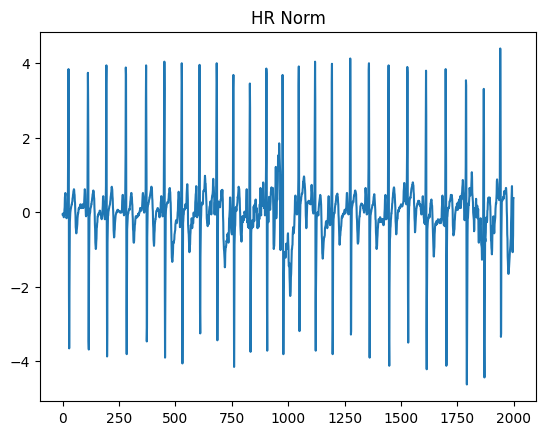

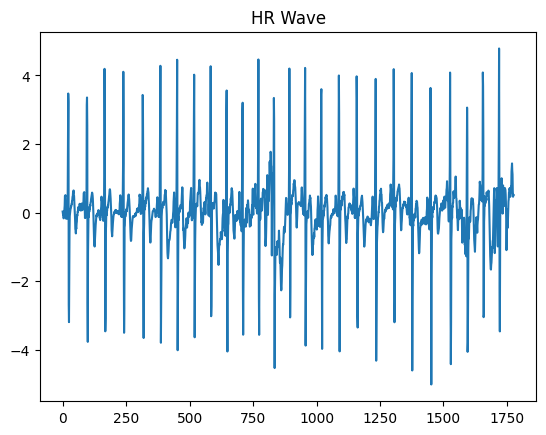

In [50]:
plt.figure(1)
plt.title("HR Norm")
plt.plot(hr_norm[:2000],label="HR Wave")
plt.figure(2)
plt.title("HR Wave")
plt.plot(hr_downsampled_signal[:1777],label="HR Wave")

In [48]:
from sklearn.preprocessing import PowerTransformer
from scipy import signal

pt = PowerTransformer()

br_norm = pt.fit_transform(br_target_array[0].reshape(-1, 1))

br_downsampled_signal = signal.resample(br_norm, 32000)


print("Ukuran sinyal asli:", br_target_array[0].shape)
print("Ukuran sinyal setelah downsampling:", br_downsampled_signal.shape)

Ukuran sinyal asli: (37500,)
Ukuran sinyal setelah downsampling: (32000, 1)


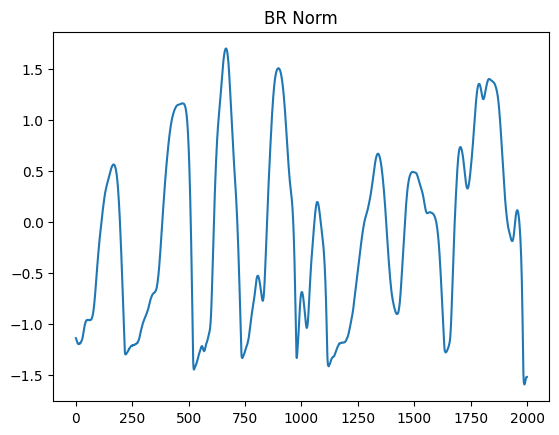

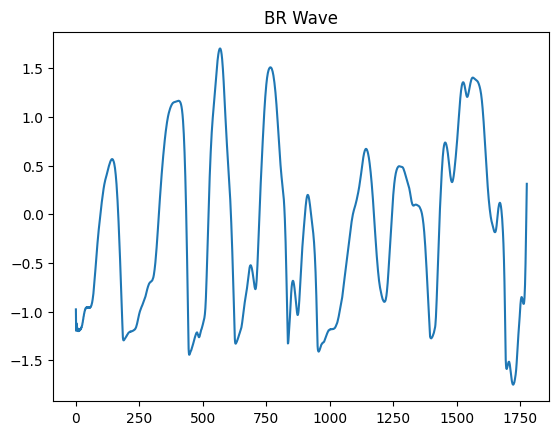

In [51]:
plt.figure(1)
plt.title("BR Norm")
plt.plot(br_norm[:2000],label="HR Wave")
plt.figure(2)
plt.title("BR Wave")
plt.plot(br_downsampled_signal[:1777],label="HR Wave")